In [1]:
from construct import *

format_word = Struct(
    "daq_major" / Byte,
    "daq_minor" / Byte,
    "data_format_major" / Byte,
    "data_format_minor" / Byte
)

two_word_file_header = Struct(
    "endian_indicator" / Int32ul,
    "data_format" / format_word
)

detector_hdr = Struct(
    "header_number" / Int32ul,
    "config_record_len" / Int32ul,
    "repeat_value" / Computed(
        lambda this: (this.config_record_len // 72) + (this.config_record_len // 144)
    )
)

charge_config_header = Struct(
    "charge_config_len" / Int32ul,
    "detector_code" / Int32sl,
    "tower_number" / Int32sl,
    "channel_post_amp" / Int32sl,
    "channel_bias" / Int32sl,
    "rtf_offset" / Int32sl,
    "delta_t" / Int32sl,
    "trigger_time" / Int32sl,
    "trace_len" / Int32sl
)

phonon_config_header = Struct(
    "phonon_config_len" / Int32ul,
    "detector_code" / Int32sl,
    "tower_number" / Int32sl,
    "post_amp_gain" / Int32sl,
    "qet_bias" / Int32sl,
    "squid_bias" / Int32sl,
    "squid_lockpoint" / Int32sl,
    "rtf_offset" / Int32sl,
    "variable_gain" / Int32sl,
    "delta_t" / Int32sl,
    "trigger_time" / Int32sl,
    "trace_len" / Int32sl
)

header_list = Struct(
    "header_number" / Int32ul,
    "charge_config" / If(
        lambda this: this.header_number == 0x10002,
        charge_config_header
    ),
    "phonon_config" / If(
        lambda this: this.header_number == 0x10001,
        phonon_config_header
    )
)

event_header = Struct(
    "event_header_word" / Int32ul,
    "event_size" / Int32ul,
    "event_identifier" / Computed(
        lambda this: (this.event_header_word >> 16) & 0xFFFF
    ),
    # 0x0: Raw, 0x1: Processed, 0x2: Monte Carlo
    "event_class" / Computed(
        lambda this: (this.event_header_word >> 8) & 0xF
    ),
    # 0x0: Per Trigger, 0x1: Occasional, 0x2: Begin File Series, 0x3: Begin File
    # 0x4: End File, 0x5: End File Series, 0x6: Per Trigger w/ Detectors that Cross Threshold
    "event_category" / Computed(
        lambda this: (this.event_header_word >> 12) & 0xF
    ),
    # 0x0: Wimp Search, 0x1: 60Co Calibration, 0x2: 60Co Low Energy Calibration,
    # 0x3: Neutron Calibration, 0x4: Random Triggers, 0x5: Pulse Triggers
    # 0x6: Test, 0x7: Data Monitering Event, 0x8: 137Cs Calibration
    "event_type" / Computed(
        lambda this: (this.event_header_word & 0xFF)
    )
)

administrative_record = Struct(
    "admin_header" / Int32ul,
    "admin_len" / Int32ul,
    "series_number_1" / Int32ul,
    "series_number_2" / Int32ul,
    "event_number_in_series" / Int32ul,
    "seconds_from_epoch" / Int32ul,
    # Epoch defined as Jan 1st 1904 for SUF (MAC Artifact)
    # Epoch defined as Jan 1st 1970 for Soudan
    "time_from_last_event" / Int32ul,
    "live_time_from_last_event" / Int32ul
)

trace_record = Struct(
    "trace_header" / Int32ul,
    "trace_len" / Int32ul,
    "trace_bookkeeping_header" / Int32ul,
    "bookkeeping_len" / Int32ul,
    "digitizer_base_address" / Int32ul,
    "digitizer_channel" / Int32ul,
    "detector_code" / Int32ul,
    "timebase_header" / Int32ul,
    "timebase_len" / Int32ul,
    "t0_in_ns" / Int32ul,
    "delta_t_ns" / Int32ul,
    "num_of_points" / Int32ul,
    "second_trace_header" / Int32ul,
    "num_samples" / Int32ul
    # Should be a power of two (1024, 2048, etc)
)

data_sample = Struct(
    "data_selection" / Int32ul,
    "sample_a" / Computed(
        lambda this: (this.data_selection >> 16) & 0xFFFF
    ),
    "sample_b" / Computed(
        lambda this: (this.data_selection & 0xFFFF)
    )
)


trace_data = Struct(
    "trace_rcrds" / trace_record,
    "sample_data" / Array(
        this.trace_rcrds.num_samples // 2,
        data_sample
    )
)

soudan_history_buffer = Struct(
    "history_buffer_header" / Int32ul,
    "history_buffer_len" / Int32ul,
    "num_time_nvt" / Int32ul,
    "time_nvt" / Array(
        this.num_time_nvt,
        Int32ul
    ),
    "num_veto_mask_words" / Int32ul,
    "time_n_minus_veto_mask" / Array(
        this.num_time_nvt * this.num_veto_mask_words,
        Int32ul
    ),
    "num_trigger_times" / Int32ul,
    "trigger_times" / Array(
        this.num_trigger_times,
        Int32ul
    ),
    "num_trigger_mask_words" / Int32ul,
    "trig_times_minus_trig_mask" / Array(
        this.num_trigger_times * this.num_trigger_mask_words,
        Int32ul
    )
)

trigger_record = Struct(
    "trigger_header" / Int32ul,
    "trigger_len" / Int32ul,
    "trigger_time" / Int32ul,
    "individual_trigger_masks" / Array(
        6,
        Int32ul
    )
)

tlb_trigger_mask_record = Struct(
    "tlb_mask_header" / Int32ul,
    "tlb_len" / Int32ul,
    "tower_mask" / Array(
        6,
        Int32ul
    )
)

gps_data = Struct(
    "tlb_mask_header" / Int32ul,
    "length" / Int32ul,
    "gps_year_day" / If(
        this.length > 0,
        Int32ul
    ),
    "gps_status_hour_minute_second" / If(
        this.length > 0,
        Int32ul
    ),
    "gps_microsecs_from_gps_second" / If(
        this.length > 0,
        Int32ul
    )
)

detector_trigger_threshold_data = Struct(
    "threshold_header" / Int32ul,
    "len_to_next_header" / Int32ul,
    "minimum_voltage_level" / Int32ul,
    "maximum_voltage_level" / Int32ul,
    "dynamic_range" / Int32ul,
    "tower_number" / Int32ul,
    "detector_codes" / Array(
        6,
        Int32ul
    ),
    "operations_codes" / Array(
        9,
        Int32ul
    ),
    "adc_values" / Array(
        54,
        Int32ul
    )
)

detector_trigger_rates = Struct(
    "detector_trigger_header" / Int32ul,
    "len_to_next_header" / Int32ul,
    "clocking_interval" / Int32ul,
    "tower_number" / Int32ul,
    "detector_codes" / Array(
        6,
        Int32ul
    ),
    "j_codes" / Array(
        5,
        Int32ul
    ),
    "counter_values" / Array(
        30,
        Int32ul
    )
)

veto_trigger_rates = Struct(
    "veto_trigger_header" / Int32ul,
    "len_to_next_header" / Int32ul,
    "clocking_interval" / Int32ul,
    "num_entries" / Int32ul,
    "detector_code" / Array(
        this.num_entries,
        Int32ul
    ),
    "counter_value_det_code" / Array(
        this.num_entries,
        Int32ul
    )
)


logical_records = Struct(
    "event_hdr" / Peek(Int32ul),  # Peek to check first
    "next_section" / Struct(
        "next_header" / Peek(Int32ul),  # Peek without consuming
        "section" / Switch(
            lambda this: (
                this.next_header if ((this.next_header >> 16) != 0xA980) 
                else 0xA980  # Use 0xA980 as identifier for event_header
            ),
            {
                0xA980: event_header,
                0x00000002: administrative_record,
                0x00000011: trace_data,
                0x00000021: soudan_history_buffer,
                0x00000060: gps_data,
                0x00000080: trigger_record,
                0x00000081: tlb_trigger_mask_record,
                0x00000022: detector_trigger_rates,
                0x00000031: veto_trigger_rates,
            }
        )
    )
)

In [2]:
soudan = Struct(
    "file_hdr" / two_word_file_header,
    "detector_hdr" / detector_hdr,
    "hdrs" / Array(
        this._root.detector_hdr.repeat_value,
        header_list
    ),
    "logical_rcrds" / GreedyRange(logical_records)
)

# Parsing instructions to create smaller files faster
test = Struct(
    "file_hdr" / two_word_file_header,
    "detector_hdr" / detector_hdr,
    "hdrs" / Array(
        this._root.detector_hdr.repeat_value,
        header_list
    ),
    "logical_rcrds" / Array(
        1000,
        logical_records
    )
)

In [11]:
import h5py
import numpy as np

def parse_file(input_path, output_path):
    with open(input_path, 'rb') as f:
        raw_data = f.read()
        # Switch between soudan and test for different amounts of parsing

        #parsed_data = test.parse(raw_data)
        parsed_data = soudan.parse(raw_data)

    with h5py.File(output_path, 'w') as f:
        
        # Initializing header groups to fill with datasets
        file_hdr_grp = f.create_group('file_hdr')
        detector_hdr_grp = f.create_group('detector_hdr')

        # Initializing arrays for the header information
        file_hdr_word_list = []
        det_hdr_list = []

        # file_hdr and detector_hdr contain no arrays
        for file_hdr_type in parsed_data.file_hdr:
            hdr_type_grp = file_hdr_grp.create_group(f'{file_hdr_type}')
            file_hdr_word_list.append(hdr_type_grp)
            if file_hdr_type == 'data_format':
                for attr_name in ['daq_major', 'daq_minor', 'data_format_major', 'data_format_minor']:
                    if hasattr(parsed_data.file_hdr.data_format, attr_name):
                        attr_value = getattr(parsed_data.file_hdr.data_format, attr_name)
                        hdr_type_grp.create_dataset(attr_name, data=attr_value)
            elif file_hdr_type == "endian_indicator":
                hdr_type_grp.create_dataset('endian_indicator', data=parsed_data.file_hdr.endian_indicator)
        
        for det_data_type in parsed_data.detector_hdr:
            det_type_grp = detector_hdr_grp.create_group(f'{det_data_type}')
            det_hdr_list.append(det_type_grp)
            if det_data_type == 'header_number':
                det_type_grp.create_dataset('header_number', data=parsed_data.detector_hdr.header_number)
            elif det_data_type == 'config_record_len':
                det_type_grp.create_dataset('config_record_len', data=parsed_data.detector_hdr.config_record_len)
            elif det_data_type == 'repeat_value':
                det_type_grp.create_dataset('repeat_value', data=parsed_data.detector_hdr.repeat_value)


        # hdrs contains an array of charge and phonon headers
        hdrs_grp           = f.create_group('hdrs')
        charge_config_grp  = hdrs_grp.create_group('charge_config')
        phonon_config_grp  = hdrs_grp.create_group('phonon_config')
        hdrs_array         = []
        charge_config_list = []
        phonon_config_list = []

        charge_hdr_count = 0
        phonon_hdr_count = 0

        # Create groups for each header and populate them with relevant datasets
        for i, header in enumerate(parsed_data.hdrs):
            # Collecting charge_config data
            if header.header_number == 0x10002:
                # HDF5 groups require unique names if at same level of structure
                charge_config_hdr_grp = charge_config_grp.create_group(f'charge_config_{charge_hdr_count}')
                charge_hdr_count += 1
                charge_config_list.append(charge_config_hdr_grp)
                hdrs_array.append(charge_config_hdr_grp)
                for attr_name in ['charge_config_len', 'detector_code', 'tower_number',
                                  'channel_post_amp', 'rtf_offset', 'delta_t', 'trigger_time',
                                  'trace_len']:
                    if hasattr(header.charge_config, attr_name):
                        attr_value = getattr(header.charge_config, attr_name)
                        charge_config_hdr_grp.create_dataset(attr_name, data=attr_value)
                
            # Collecting phonon_config data
            elif header.header_number == 0x10001:
                phonon_config_hdr_grp = phonon_config_grp.create_group(f'phonon_config_{phonon_hdr_count}')
                phonon_hdr_count += 1
                phonon_config_list.append(header)
                hdrs_array.append(phonon_config_hdr_grp)
                for attr_name in ['phonon_config_len', 'detector_code', 'tower_number',
                                  'post_amp_gain', 'qet_bias', 'squid_bias', 'squid_lockpoint',
                                  'rtf_offset', 'variable_gain', 'delta_t', 'trigger_time', 'trace_len']:
                    if hasattr(header.phonon_config, attr_name):
                        attr_value = getattr(header.phonon_config, attr_name)
                        phonon_config_hdr_grp.create_dataset(attr_name, data=attr_value)
        
        # Dictionary for creating groups
        logical_record_options = {
            0xA980: "event_header",
            0x00000002: "admin_rcrd",
            0x00000011: "trace_data",
            0x00000021: "soudan_history_buffer",
            0x00000060: "gps_data",
            0x00000080: "trigger_rcrd",
            0x00000081: "tlb_trigger_mask_rcrd",
            0x00000022: "detector_trigger_rates",
            0x00000031: "veto_trigger_rates",
        }

        # Creating groups that can hold each event's records
        logical_rcrd_grp       = f.create_group('logical_rcrds')
        event_hdr_grp          = logical_rcrd_grp.create_group('event_hdr')
        admin_rcrd_grp         = logical_rcrd_grp.create_group('admin_rcrd')
        trigger_rcrd_grp       = logical_rcrd_grp.create_group('trigger_rcrd')
        tlb_trig_mask_rcrd_grp = logical_rcrd_grp.create_group('tlb_trig_mask_rcrd')
        gps_data_grp           = logical_rcrd_grp.create_group('gps_data')
        trace_data_grp         = logical_rcrd_grp.create_group('trace_data')
        soudan_buffer_grp      = logical_rcrd_grp.create_group('soudan_buffer')
        detector_trig_grp      = logical_rcrd_grp.create_group('detector_trigger_rates')
        veto_trig_grp          = logical_rcrd_grp.create_group('veto_trigger_rates')

        # Initializing arrays to store the created groups of logical_rcrd data
        event_hdr_array          = []
        admin_rcrd_array         = []
        trigger_rcrd_array       = []
        tlb_trig_mask_rcrd_array = []
        gps_data_array           = []
        trace_data_array         = []
        soudan_buffer_array      = []
        detector_trig_array      = []
        veto_trig_array          = []

        # Initializing arrays for storing trace_data data samples
        phonon_pulse_array       = []
        charge_pulse_array       = []
        veto_array               = []
        error_array              = []

        # Counters for group naming iteration
        event_count    = 0
        admin_count    = 0
        trigger_count  = 0
        tlb_count      = 0
        gps_count      = 0
        trace_count    = 0
        soudan_count   = 0
        detector_count = 0
        veto_count     = 0

        # Using to find the unique information related to these groups
        trace_set = set()
        detector_type_set = set()
        channel_number_set = set()
        error_set = set()
        veto_set = set()

        # Loop through all of the Structs in logical_rcrds
        for i, record_option in enumerate(parsed_data.logical_rcrds):
            # Handle event headers separately
            if (record_option.next_section.next_header >> 16) == 0xA980:
                # Storing event_hdr data
                events = []
                # Loop through attributes of event_hdr and store them in event_group_i
                event_group_i = event_hdr_grp.create_group(f'event_group_{event_count}')
                event_count += 1
                for attr_name in ['event_header_word', 'event_size', 'event_identifier',
                                'event_class', 'event_category', 'event_type']:
                    if hasattr(record_option.next_section.section, attr_name):
                        attr_value = getattr(record_option.next_section.section, attr_name)
                        event_data = event_group_i.create_dataset(attr_name, data=attr_value)
                        events.append(event_data)
                event_hdr_array.append(events)
            
            # Iterate through the options in logical_rcrds using the type dictionary
            for value, type in logical_record_options.items():
                if record_option.next_section.next_header == value:
                    if type == 'admin_rcrd':
                        # Store admin_rcrd data in an array
                        admins = []
                        admin_group_i = admin_rcrd_grp.create_group(f'{type}_group_{admin_count}')
                        admin_count += 1
                        for attr_name in ['admin_header', 'admin_len', 'series_number_1', 'series_number_2',
                                        'event_number_in_series', 'seconds_from_epoch', 'time_from_last_event',
                                        'live_time_from_last_event']:
                            if hasattr(record_option.next_section.section, attr_name):
                                attr_value = getattr(record_option.next_section.section, attr_name)
                                admin_data = admin_group_i.create_dataset(attr_name, data=attr_value)
                                admins.append(admin_data)
                        # Store each admin_rcrd data array in higher level array
                        admin_rcrd_array.append(admins)
                
                    if type == 'trigger_rcrd':
                        # Store trigger_rcrd data in an array
                        triggers = []
                        trigger_group_i = trigger_rcrd_grp.create_group(f'{type}_group_{trigger_count}')
                        trigger_count += 1
                        for attr_name in ['trigger_header', 'trigger_len', 'trigger_time', 'individual_trigger_masks']:
                            if hasattr(record_option.next_section.section, attr_name):
                                attr_value = getattr(record_option.next_section.section, attr_name)
                                trigger_data = trigger_group_i.create_dataset(attr_name, data=attr_value)
                                triggers.append(trigger_data)
                        # Store each trigger_rcrd array in higher level array
                        trigger_rcrd_array.append(triggers)

                    if  type == 'tlb_trigger_mask_rcrd':
                        # Store tlb_trigger_mask_rcrd data in an array
                        tlb_trig_mask = []
                        tlb_trig_group_i = tlb_trig_mask_rcrd_grp.create_group(f'{type}_group_{tlb_count}')
                        tlb_count += 1
                        for attr_name in ['tlb_mask_header', 'tlb_len', 'tower_mask']:
                            if hasattr(record_option.next_section.section, attr_name):
                                attr_value = getattr(record_option.next_section.section, attr_name)
                                tlb_trig_data = tlb_trig_group_i.create_dataset(attr_name, data=attr_value)
                                tlb_trig_mask.append(tlb_trig_data)
                        # Store each array in higher level array
                        tlb_trig_mask_rcrd_array.append(tlb_trig_mask)

                    if type == 'gps_data':
                        # Storing gps_data in array
                        gps = []
                        # Loop through attributes of gps_data and store them in gps_data_group_i
                        gps_data_group_i = gps_data_grp.create_group(f'{type}_group_{gps_count}')
                        gps_count += 1
                        # If length = 0, only tlb_mask_header and length have values
                        if record_option.next_section.section.length == 0:
                            for attr_name in ['tlb_mask_header', 'length']:
                                if hasattr(record_option.next_section.section, attr_name):
                                    attr_value = getattr(record_option.next_section.section, attr_name)
                                    gps_dataset = gps_data_group_i.create_dataset(attr_name, data=attr_value)
                                    gps.append(gps_dataset)
                        else:
                            for attr_name in ['tlb_mask_header', 'length', 'gps_year_day', 'gps_status_hour_minute',
                                            'gps_microsecs_from_gps_second']:
                                if hasattr(record_option.next_section.section, attr_name):
                                    attr_value = getattr(record_option.next_section.section, attr_name)
                                    gps_dataset = gps_data_group_i.create_dataset(attr_name, data=attr_value)
                                    gps.append(gps_dataset)
                        # Store gps array in higher level array
                        gps_data_array.append(gps)

                    # trace_data contains the actual data samples taken by the detector
                    # As well as the header information describing the events and detectors
                    if type == "trace_data":
                        #print(record_option.next_section.section)
                        if record_option.next_section.section.trace_rcrds:
                            trace_record_group_i = trace_data_grp.create_group(f'{type}_group_{trace_count}')
                            trace_count += 1
                            # Store trace_rcrd data in an array
                            trace_rcrd = []
                            for attr_name in ['trace_header', 'trace_len', 'trace_bookkeeping_header', 'bookkeeping_len',
                                  'digitizer_base_address', 'digitizer_channel', 'detector_code', 'timebase_header',
                                  'timebase_len', 't0_in_ns', 'delta_t_ns', 'num_of_points', 'second_trace_header',
                                  'num_samples']:
                                if hasattr(record_option.next_section.section.trace_rcrds, attr_name):
                                    attr_value = getattr(record_option.next_section.section.trace_rcrds, attr_name)
                                    trace_rcrd_dataset = trace_record_group_i.create_dataset(attr_name, data=attr_value)
                                    trace_rcrd.append(trace_rcrd_dataset)
                            # Store each trace_rcrd array in higher level array
                            trace_data_array.append(trace_rcrd)

                        if record_option.next_section.section.sample_data:
                            # Store data samples in trace array          
                            trace = []
                            for data in record_option.next_section.section.sample_data:
                                trace.append(data.sample_a)
                                trace.append(data.sample_b)
                        
                        # Which array to store the trace array in depends on the detector type
                        detector_code = record_option.next_section.section.trace_rcrds.detector_code
                        # Handling single digit detector types:
                        if len(str(detector_code)) == 8:
                            detector_type = int(str(detector_code)[:2])
                        else:
                            detector_type = int(str(detector_code)[:1])
                        detector_number = int(str(detector_code)[-6:-3])
                        channel_number = int(str(detector_code)[-3:])

                        # Inspecting detector codes for detector_types not described in documentation
                        #if detector_type in [91, 90]:
                        #    print(detector_code)

                        # Finding unique values for detector type
                        detector_type_set.add(detector_type)
                        channel_number_set.add(channel_number)
                        trace_set.add(len(trace))
                        # Use detector types to sort data into charge and phonon groups
                        if detector_type in [1, 2, 4, 5, 6]: # BLIP, FLIP/ZIP/mZIP/ENDCAP (class I)
                            if channel_number in [0, 1]:
                                charge_pulse_array.append(trace)
                                trace_record_group_i.create_dataset(f"charge_trace", data=trace)
                            else:
                                phonon_pulse_array.append(trace)
                                trace_record_group_i.create_dataset(f"phonon_trace", data=trace)
                        elif detector_type == 3:
                            veto_array.append(trace)
                            veto_set.add(len(trace))
                            trace_record_group_i.create_dataset(f'veto_trace', data=trace)
                        elif detector_type == 7: # ENDCAP (class II)
                            if channel_number == 0:
                                charge_pulse_array.append(trace)
                                trace_record_group_i.create_dataset(f"charge_trace", data=trace)
                            else:
                                phonon_pulse_array.append(trace)
                                trace_record_group_i.create_dataset(f"phonon_trace", data=trace)
                        elif detector_type == 10: # iZIP (class I)
                            if channel_number in [0, 1, 6, 7]:
                                charge_pulse_array.append(trace)
                                trace_record_group_i.create_dataset(f"charge_trace", data=trace)
                            else:
                                phonon_pulse_array.append(trace)
                                trace_record_group_i.create_dataset(f"phonon_trace", data=trace)
                        elif detector_type == 11: # iZIP (class II)
                            if channel_number in [0, 1, 6, 7]:
                                charge_pulse_array.append(trace)
                                trace_record_group_i.create_dataset(f"charge_trace", data=trace)
                            else:
                                phonon_pulse_array.append(trace)
                                trace_record_group_i.create_dataset(f"phonon_trace", data=trace)
                        else:
                            error_array.append(trace)
                            trace_record_group_i.create_dataset(f'error_trace', data=trace)
                            #error_set.add(len(trace))
                            #print(f"Detector Code {detector_code} not consistent with documentation")

                    if type == 'soudan_history_buffer':
                        # Store soudan_history_buffer data in an array
                        soudan_buffer = []
                        soudan_buffer_group_i = soudan_buffer_grp.create_group(f'{type}_group_{soudan_count}')
                        soudan_count += 1
                        for attr_name in ['history_buffer_header', 'history_buffer_len', 'num_time_nvt', 'time_nvt',
                              'num_veto_mask_words', 'time_n_minus_veto_mask', 'num_trigger_times', 
                              'trigger_times', 'num_trigger_mask_words', 'trig_times_minus_trig_mask']:
                            if hasattr(record_option.next_section.section, attr_name):
                                attr_value = getattr(record_option.next_section.section, attr_name)
                                soudan_buffer_data = soudan_buffer_group_i.create_dataset(attr_name, data=attr_value)
                                soudan_buffer.append(soudan_buffer_data)
                        # Store each soudan_history_buffer array in higher level array
                        soudan_buffer_array.append(soudan_buffer)

                    if type == 'detector_trigger_rates':
                        # Store detector_trigger_rate data in an array
                        detector = []
                        detector_group_i = detector_trig_grp.create_group(f'{type}_group_{detector_count}')
                        detector_count += 1
                        for attr_name in ['detector_trigger_header', 'len_to_next_header', 'clocking_interval',
                                          'tower_number', 'detector_codes', 'j_codes', 'counter_values']:
                            if hasattr(record_option.next_section.section, attr_name):
                                attr_value = getattr(record_option.next_section.section, attr_name)
                                detector_trig_data = detector_group_i.create_dataset(attr_name, data=attr_value)
                                detector.append(detector_trig_data)
                        # Store each detector_trigger_rate in a higher level array
                        detector_trig_array.append(detector)
                        
                    if type == 'veto_trigger_rates':
                        # Store veto data in an array
                        veto = []
                        veto_group_i = veto_trig_grp.create_group(f'{type}_group_{veto_count}')
                        veto_count += 1
                        for attr_name in ['veto_trigger_header', 'len_to_next_header', 'clocking_interval',
                                          'num_entries', 'detector_code', 'counter_value_det_code']:
                            if hasattr(record_option.next_section.section, attr_name):
                                attr_value = getattr(record_option.next_section.section, attr_name)
                                veto_trig_data = veto_group_i.create_dataset(attr_name, data=attr_value)
                                veto.append(veto_trig_data)
                        # Store each veto array in higher level array
                        veto_trig_array.append(veto)


        # Print data about the arrays and their values
        #print(f'Detector set:     {detector_type_set}')
        #print(f'Trace length set: {trace_set}')
        #print(f'Error length set: {error_set}')
        #print(f'Veto length set:  {veto_set}')
        #print(f'Charge array len: {len(charge_pulse_array)}')
        #print(f'Phonon array len: {len(phonon_pulse_array)}')
        #print(f'Veto array len:   {len(veto_array)}')
        #print(f'Error array len:  {len(error_array)}')


#input_path  = "../01120210_0727_F0114"
#input_path = "/data3/afisher/test/01120210_0727_F0001"
input_path = "/data3/afisher/test/01130208_1838_F0006"
#output_path = "/home/afisher@novateur.com/dataReaderWriter/scdms_soudan/parsed.hdf5"

# For final files, save onto novateur network:
output_path = "/data3/afisher/test/parsed_file.hdf5"

#charge_array, phonon_array, veto_array, error_array = parse_file(input_path, output_path)
parse_file(input_path, output_path)

In [12]:
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import re

directory = '/data3/afisher/cdmslite-run3-cuts-output/'
# Load cdms id file
id_path = directory+'ID_CDMSliteR3.csv'
# Create array of file names in directory
file_names = []

# Load id file into a dataframe
cdms_ids = pd.read_csv(id_path, header = None, names = ['index', 'series-event'])
# Split series-event column into 'series_number' and 'event_number'
cdms_ids[['series_number', 'event_number']] = cdms_ids['series-event'].str.split('-', expand = True)
cdms_ids = cdms_ids.drop('series-event', axis=1)

for file in os.listdir(directory):
    if os.path.isfile(os.path.join(directory, file)):
        file_names.append(file)

        
def create_tables(output_path):
    # Create a dataframe with the ID indices
    bool_df = pd.DataFrame(cdms_ids['index'])
    with h5py.File(output_path, 'w') as f:
        short_names = []

        # pattern fits files like: cut_output_bg-restricted_IsGlitch_chisq_CDMSliteR3.csv
        pattern = r'(?:(cut_output_bg-|out_bg-))(?:restricted_)(.*?)(?:_CDMSliteR3.csv)'

        # allCuts_pattern fits files like: out_bg-restricted_allCutsOld_inclPmult.csv
        allCuts_pattern = r'(?:.*?-restricted_)(.*?)(?:\.csv)'

        for file in file_names:
            if file in ['ID_CDMSliteR3.csv', 'README.md']:
                continue
            # Skip test files
            if "_small" in file:
                continue
            match = re.search(pattern, file)
            allCuts_match = re.search(allCuts_pattern, file)
            # Fill list with names to create easy to read group names
            if match:
                name = match.group(1) + match.group(2)

            elif allCuts_match:
                name = allCuts_match.group(1)
            
            if name:
                short_names.append(name)

                # Load data into df
                cut_data_df = pd.read_csv(os.path.join(directory+file), header = None, names = [name])
                # Convert df into boolean - turns 1's and 0's into True and False
                cut_data_df[name] = cut_data_df[name].astype(bool)
                # Add the boolean column to the main DataFrame
                bool_df[name] = cut_data_df[name]

        cut_data_group = f.create_group("cut_data")

        # Save the 'index' as a separate dataset
        cut_data_group.create_dataset('index', data=bool_df['index'].to_numpy())

        # Save each boolean column as a separate dataset
        for col in bool_df.columns[1:]:
            #print(f"Saving column {col} with type {bool_df[col].dtype}")
            cut_data_group.create_dataset(col, data=bool_df[col].to_numpy())

        id_group = f.create_group('UID')

        id_group.create_dataset('index', data=cdms_ids.iloc[:,0].to_numpy())
        id_group.create_dataset('series_ids', data=cdms_ids.iloc[:,1].to_numpy())

    return bool_df

def relate_index(index, bool_df):
    # Load ID data into function
    directory = '/data3/afisher/cdmslite-run3-cuts-output/'
    id_path = directory+'ID_CDMSliteR3.csv'
    cdms_ids = pd.read_csv(id_path, header = None, names = ['index', 'series-event'])

    # Split series-event column into 'series_number' and 'event_number'
    cdms_ids[['series_number', 'event_number']] = cdms_ids['series-event'].str.split('-', expand = True)
    cdms_ids = cdms_ids.drop('series-event', axis=1)

    series = cdms_ids.loc[index, 'series_number']
    event_number = cdms_ids.loc[index, 'event_number']
    cut_info = bool_df.loc[index]
    
    return series, event_number, cut_info

# Given an event number, return index
def relate_event(event_number):
    # Load ID data into function
    directory = '/data3/afisher/cdmslite-run3-cuts-output/'
    id_path = directory+'ID_CDMSliteR3.csv'
    cdms_ids = pd.read_csv(id_path, header = None, names = ['index', 'series-event'])
    
    # Split series-event column into 'series_number' and 'event_number'
    cdms_ids[['series_number', 'event_number']] = cdms_ids['series-event'].str.split('-', expand = True)
    cdms_ids = cdms_ids.drop('series-event', axis=1)

    row = cdms_ids[cdms_ids['event_number'] == event_number]

    if not row.empty:
        index = row['index'].values[0]
    else:
        print(f'Event number {event_number} not found.')
        index = None
    
    return index

def get_series_numbers(hdf5_file_path):
    event_numbers = []
    
    with h5py.File(hdf5_file_path, 'r') as f:
        if 'logical_rcrds/admin_rcrd/' in f:
            header_group = f['logical_rcrds/admin_rcrd']
            header_groups = [key for key in header_group.keys() if key.startswith('admin_rcrd')]
            num_header_groups = len(header_groups)
            for i in range(num_header_groups):
                admin_group = header_groups[i]
                event_num_path = f'logical_rcrds/admin_rcrd/{admin_group}/event_number_in_series'
                series_num_1_path = f'logical_rcrds/admin_rcrd/{admin_group}/series_number_1'
                series_num_2_path = f'logical_rcrds/admin_rcrd/{admin_group}/series_number_2'

                if event_num_path in f:
                    event_data = f[event_num_path]
                    event_numbers.append(int(event_data[()]))
                if series_num_1_path in f:
                    series_1_number = f[series_num_1_path]
                    series_1_number = int(series_1_number[()])
                if series_num_2_path in f:
                    series_2_number = f[series_num_2_path]
                    series_2_number = int(series_2_number[()])

            series_number = f'{series_1_number}{series_2_number}'
    # Sort event numbers
    event_numbers = sorted(event_numbers)

    return event_numbers, series_number


def get_event_data(hdf5_file_path, event_number):

    with h5py.File(hdf5_file_path, 'r') as f:
        # Load admin_rcrds to find event_number
        admin_group = f['logical_rcrds/admin_rcrd']
        admin_groups = [key for key in admin_group.keys() if key.startswith('admin_rcrd')]
        admin_groups = sorted(admin_groups, key=lambda x: int(re.search(r'\d+', x).group()))
        num_admin_groups = len(admin_groups)

        # Load trace_data to relate event_number to data
        trace_group = f['logical_rcrds/trace_data']
        trace_groups = [key for key in trace_group.keys() if key.startswith('trace_data')]
        trace_groups = sorted(trace_groups, key=lambda x: int(re.search(r'\d+', x).group()))
        num_trace_groups = len(trace_groups)

        # Ratio between trace groups and admin groups
        step_size = num_trace_groups/num_admin_groups
        #print(f'Step size: {step_size}')

        # Find the requested event number in the file
        for i in range(num_admin_groups):
            # Iterate through admin groups to find a match
            admin_group = admin_groups[i]
            event_num_path = f'logical_rcrds/admin_rcrd/{admin_group}/event_number_in_series'
            event_num = f[event_num_path]
            event_num = int(event_num[()])

            # Find match - extract data
            if event_number == event_num:
                #print(f"Event {event_number} found at location {i}")
                #print(f'Admin group: {admin_group}')

                # Find corresponding trace_data
                trace_group = trace_groups[i]
                #print(f'Trace group: {trace_group}')

                trace_det_code_path = f'logical_rcrds/trace_data/{trace_group}/detector_code'
                trace_det_code = f[trace_det_code_path]
                trace_det_code = int(trace_det_code[()])
                #print(f'Trace detector code: {trace_det_code}')

                # Collect traces with matching detector codes
                trace_match_list = []
                trace_path_base = f'logical_rcrds/trace_data/'
                # Allow for missing data
                type = None
                for trace in trace_groups:
                    # Find all traces with matching detector codes
                    match_det_code_path = f'logical_rcrds/trace_data/{trace}/detector_code'
                    match_det_code = f[match_det_code_path]
                    match_det_code = int(match_det_code[()])
                    #print(f'Trace det code: {trace_det_code}')
                    type_path_base = f'{trace_path_base}{trace}/'

                    # Find if trace is charge, phonon, veto, or error
                    if match_det_code == trace_det_code:
                        charge_match_path = f'{type_path_base}charge_trace'
                        phonon_match_path = f'{type_path_base}phonon_trace'
                        veto_match_path = f'{type_path_base}veto_trace'
                        error_match_path = f'{type_path_base}error_trace'

                        if charge_match_path in f:
                            trace_data = f[charge_match_path][()]
                            trace_match_list.append(trace_data)
                            type = 'charge_trace'
                        elif phonon_match_path in f:
                            trace_data = f[phonon_match_path][()]
                            trace_match_list.append(trace_data)
                            type = 'phonon_trace'
                        elif veto_match_path in f:
                            trace_data = f[veto_match_path][()]
                            trace_match_list.append(trace_data)
                            type = 'veto_trace'
                        elif error_match_path in f:
                            trace_data = f[error_match_path][()]
                            trace_match_list.append(trace_data)
                            type = 'error_trace'
                        else:
                            print(f'No valid trace found for {event_number}.')
                            trace_data = None
                            type = None

                return trace_match_list, type

def fetch_data(event_number, bool_df, hdf5_file_path):
    # Use event number to find cut data
    index = relate_event(event_number)
    series, event_number, cut_info = relate_index(index, bool_df)

    # Use event number to find matching data
    trace_match_list, trace_type = get_event_data(hdf5_file_path, event_number)

    # Plot data
    x = np.arange(len(trace_match_list[0]))
    for trace in trace_match_list:
        plt.scatter(x, trace)
    plt.title(trace_type)
    plt.show()

    print(cut_info)

    return cut_info

In [13]:
# fetch_data test
output_path = '/home/afisher@novateur.com/dataReaderWriter/scdms_soudan/metadata.hdf5'
# Load hdf5 file
hdf5_file_path = "/data3/afisher/test/parsed_file.hdf5"
bool_df = create_tables(output_path)

event_numbers, series_number = get_series_numbers(hdf5_file_path)
print(f'Series number: {series_number}')
event_number = event_numbers[0]
print(f'Event number: {event_number}')
index = relate_event(event_number)
print(f'Index: {index}')
cut_info = fetch_data(event_number, bool_df, hdf5_file_path)

Series number: 11302081838
Event number: 60001
Event number 60001 not found.
Index: None
Event number 60001 not found.


KeyError: None

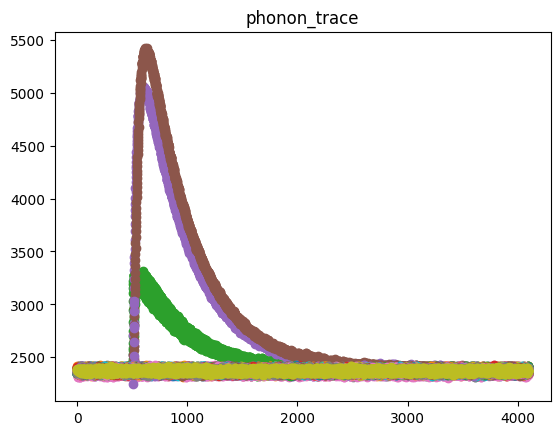

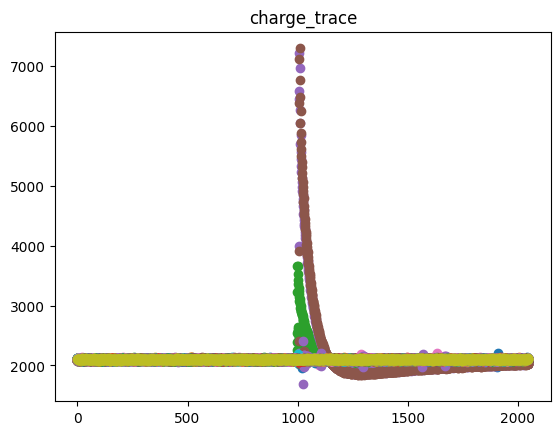

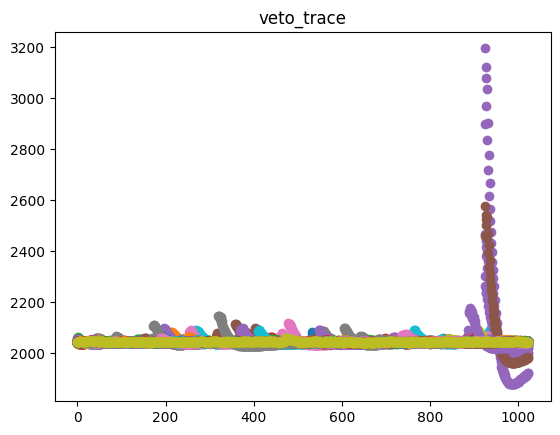

In [33]:
hdf5_file_path = "/data3/afisher/test/parsed_file.hdf5"
event_numbers, series_number = get_series_numbers(hdf5_file_path)

# Giving an example of phonon data
phonon_traces, phonon_type = get_event_data(hdf5_file_path, event_numbers[0])
x = np.arange(len(phonon_traces[0]))
for array in phonon_traces:
    plt.scatter(x, array)
plt.title(phonon_type)
plt.show()

# Giving an example of charge data
charge_traces, charge_type = get_event_data(hdf5_file_path, event_numbers[8])
x = np.arange(len(charge_traces[0]))
for array in charge_traces:
    plt.scatter(x, array)
plt.title(charge_type)
plt.show()

# Giving an example of veto data
veto_traces, veto_type = get_event_data(hdf5_file_path, event_numbers[182])
x = np.arange(len(veto_traces[0]))
for array in veto_traces:
    plt.scatter(x, array)
plt.title(type)
plt.show()